### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")
# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
Time_matrix[1,:,4,:]

array([[2., 3., 3., 5., 7., 0., 6.],
       [0., 0., 0., 0., 0., 0., 0.],
       [5., 6., 5., 7., 7., 9., 7.],
       [5., 6., 5., 3., 5., 4., 4.],
       [4., 1., 4., 2., 3., 1., 2.]])

#### Tracking the state-action pairs for checking convergence


In [3]:
#call environment
env = CabDriver()

In [4]:
States_track = collections.defaultdict(dict)
print(len(States_track))

0


In [5]:
#random state
env.state_init

[3, 9, 4]

In [6]:
#checking action space
env.action_space

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (0, 0)]

In [7]:
len(env.state_space)

840

In [8]:
# Tracking sample state-action pairs
sampled_states = [(1, 18, 1), (3, 4, 3), (2, 3, 3), (4, 16, 5)]

sampled_actions = [(0, 4), (3, 0), (2, 1) ]
action_idx = [4, 13, 10 ]

States_track = collections.defaultdict(dict)

def init_sample_states():
    for st in sampled_states:
        st_key = "-".join( [str(i) for i in st ] )
        for ac in sampled_actions:
            ac_key = "-".join( [str(i) for i in ac ] )
            States_track[st_key][ac_key] = []


In [26]:
#initialize tracking function
init_sample_states()


In [10]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [11]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1.0
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0005 #for 10k
        
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)


        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        """
        Function that takes in the agent and constructs the network to train it return model params agent
        """
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model

    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals)]

    def append_sample(self, state, action_index, reward, next_state, terminal_state):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, terminal_state))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_bool = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                done.append(done_bool)
                update_output[i] = env.state_encod_arch1(next_state)
                

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    #defining function to predict the tracking state.        
    def track_sampled_states_reward(self):
        for state in sampled_states:
            enc_state = env.state_encod_arch1(state).reshape(1, 36)
            q_value = self.model.predict(enc_state)
            state_key = "-".join([str(i) for i in state ] )
            for idx, ac_idx in enumerate(action_idx):
                action_key =  "-".join([str(i) for i in  sampled_actions[idx]])
                reward_value = q_value[0][ac_idx]
                if action_key in States_track[state_key].keys():
                    States_track[state_key][action_key].append(reward_value)

    def save(self, name):
        with open(name, 'wb') as file:
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

In [12]:
#number of episode's
Episodes = 10000

### DQN block

In [13]:
start_time = time.time()
#agent = DQNAgent(state_size = len(state_encod_arch1(env.state_init), action_size = len(env.action_space)))
agent = DQNAgent(state_size = 36, action_size = 21)
#agent = DQNAgent(36,21)
rewards_per_episode, episodes = [], []
#call Environment
env = CabDriver()
action_space, state_space, state = env.reset()
for episode in range(Episodes):
    # Write code here
    # Call the environment
    terminal_state = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    state = env.state_init
    #print("Initial State:: ",state)

    total_time = 0  # Total time driver rode in this episode
    while not terminal_state:
        # 1. Get a list of the ride requests driver got.
        possible_actions_index, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_index, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, trip_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += trip_time
        if (total_time > 24*30):
            # if ride does not complete in estimated time 
            # move to next episode.
            terminal_state = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, terminal_state)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state
        
    #store total reward calculated in episode        
    rewards_per_episode.append(score)
    episodes.append(episode)
    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)
        
#     if agent.epsilon > agent.epsilon_min:
#         agent.epsilon *= agent.epsilon_decay
     #for every 10 episodes:
    if episode  % 10 == 0:
        
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,score,len(agent.memory), agent.epsilon))
        
     #save the state action pair that we are tracking.
    if episode % 5 == 0:
        agent.track_sampled_states_reward()    
    
    
    if episode % 1000 == 0:
        agent.save(name="model_weights.pkl")
                
elapsed_time = time.time() - start_time        

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________

episode 0, reward 251.0, memory_length 121, epsilon 1.0
episode 10, reward -299.0, memory_length 1288, epsilon 0.9950125290678904
episode 20, reward 105.0, memory_length 2000, epsilon 0.9900499332508306
episode 30, reward 204.0, memory_length 2000, epsilon 0.9851120884836666
episode 40, reward 149.0

episode 940, reward 855.0, memory_length 2000, epsilon 0.6250060182600179
episode 950, reward 825.0, memory_length 2000, epsilon 0.6218888376144553
episode 960, reward 639.0, memory_length 2000, epsilon 0.6187872039722228
episode 970, reward 667.0, memory_length 2000, epsilon 0.6157010397923175
episode 980, reward 566.0, memory_length 2000, epsilon 0.6126302679204743
episode 990, reward 486.0, memory_length 2000, epsilon 0.6095748115872363
episode 1000, reward 880.0, memory_length 2000, epsilon 0.6065345944060363
episode 1010, reward 972.0, memory_length 2000, epsilon 0.6035095403712862
episode 1020, reward 292.0, memory_length 2000, epsilon 0.6004995738564778
episode 1030, reward 752.0, memory_length 2000, epsilon 0.5975046196122913
episode 1040, reward 477.0, memory_length 2000, epsilon 0.5945246027647146
episode 1050, reward 898.0, memory_length 2000, epsilon 0.5915594488131715
episode 1060, reward 450.0, memory_length 2000, epsilon 0.5886090836286584
episode 1070, reward 891.0, mem

episode 2030, reward 1332.0, memory_length 2000, epsilon 0.36240880580819196
episode 2040, reward 1022.0, memory_length 2000, epsilon 0.3606013342236766
episode 2050, reward 1422.0, memory_length 2000, epsilon 0.3588028774412976
episode 2060, reward 1026.0, memory_length 2000, epsilon 0.3570133904995417
episode 2070, reward 1258.0, memory_length 2000, epsilon 0.3552328286611423
episode 2080, reward 743.0, memory_length 2000, epsilon 0.3534611474119606
episode 2090, reward 608.0, memory_length 2000, epsilon 0.35169830245987316
episode 2100, reward 1033.0, memory_length 2000, epsilon 0.3499442497336642
episode 2110, reward 712.0, memory_length 2000, epsilon 0.3481989453819246
episode 2120, reward 1201.0, memory_length 2000, epsilon 0.3464623457719541
episode 2130, reward 1277.0, memory_length 2000, epsilon 0.3447344074886725
episode 2140, reward 1129.0, memory_length 2000, epsilon 0.3430150873335325
episode 2150, reward 1198.0, memory_length 2000, epsilon 0.3413043423234407
episode 2160,

episode 3110, reward 1251.0, memory_length 2000, epsilon 0.21119727074714478
episode 3120, reward 1859.0, memory_length 2000, epsilon 0.21014396984005274
episode 3130, reward 1142.0, memory_length 2000, epsilon 0.20909592229315122
episode 3140, reward 1309.0, memory_length 2000, epsilon 0.2080531019051969
episode 3150, reward 1509.0, memory_length 2000, epsilon 0.20701548260562586
episode 3160, reward 2100.0, memory_length 2000, epsilon 0.2059830384539014
episode 3170, reward 1452.0, memory_length 2000, epsilon 0.20495574363886615
episode 3180, reward 1256.0, memory_length 2000, epsilon 0.2039335724780961
episode 3190, reward 1545.0, memory_length 2000, epsilon 0.20291649941725906
episode 3200, reward 1311.0, memory_length 2000, epsilon 0.20190449902947546
episode 3210, reward 1427.0, memory_length 2000, epsilon 0.200897546014683
episode 3220, reward 1388.0, memory_length 2000, epsilon 0.19989561519900376
episode 3230, reward 1460.0, memory_length 2000, epsilon 0.19889868153411525
epis

episode 4180, reward 1567.0, memory_length 2000, epsilon 0.12369589894609666
episode 4190, reward 1641.0, memory_length 2000, epsilon 0.12307901295153117
episode 4200, reward 1409.0, memory_length 2000, epsilon 0.12246520368869938
episode 4210, reward 1708.0, memory_length 2000, epsilon 0.12185445581233767
episode 4220, reward 1665.0, memory_length 2000, epsilon 0.12124675405371735
episode 4230, reward 1541.0, memory_length 2000, epsilon 0.12064208322026274
episode 4240, reward 1396.0, memory_length 2000, epsilon 0.1200404281951716
episode 4250, reward 1814.0, memory_length 2000, epsilon 0.11944177393703695
episode 4260, reward 2260.0, memory_length 2000, epsilon 0.11884610547947114
episode 4270, reward 1542.0, memory_length 2000, epsilon 0.11825340793073164
episode 4280, reward 1398.0, memory_length 2000, epsilon 0.11766366647334897
episode 4290, reward 1931.0, memory_length 2000, epsilon 0.11707686636375593
episode 4300, reward 1561.0, memory_length 2000, epsilon 0.11649299293191923


episode 5250, reward 1666.0, memory_length 2000, epsilon 0.07244903263668111
episode 5260, reward 1095.0, memory_length 2000, epsilon 0.0720877414541437
episode 5270, reward 1868.0, memory_length 2000, epsilon 0.07172825221889668
episode 5280, reward 1860.0, memory_length 2000, epsilon 0.07137055594369049
episode 5290, reward 1778.0, memory_length 2000, epsilon 0.07101464368609958
episode 5300, reward 1778.0, memory_length 2000, epsilon 0.07066050654829899
episode 5310, reward 1854.0, memory_length 2000, epsilon 0.07030813567684178
episode 5320, reward 1549.0, memory_length 2000, epsilon 0.06995752226243791
episode 5330, reward 1536.0, memory_length 2000, epsilon 0.06960865753973368
episode 5340, reward 1553.0, memory_length 2000, epsilon 0.0692615327870929
episode 5350, reward 2136.0, memory_length 2000, epsilon 0.0689161393263786
episode 5360, reward 1362.0, memory_length 2000, epsilon 0.06857246852273637
episode 5370, reward 1481.0, memory_length 2000, epsilon 0.06823051178437817
ep

episode 6320, reward 1556.0, memory_length 2000, epsilon 0.04243531682310059
episode 6330, reward 2073.0, memory_length 2000, epsilon 0.04222371967268833
episode 6340, reward 1567.0, memory_length 2000, epsilon 0.04201317786746652
episode 6350, reward 1463.0, memory_length 2000, epsilon 0.041803686143879054
episode 6360, reward 1986.0, memory_length 2000, epsilon 0.041595239264621955
episode 6370, reward 1881.0, memory_length 2000, epsilon 0.04138783201851238
episode 6380, reward 1495.0, memory_length 2000, epsilon 0.04118145922035835
episode 6390, reward 1965.0, memory_length 2000, epsilon 0.04097611571082917
episode 6400, reward 1657.0, memory_length 2000, epsilon 0.04077179635632643
episode 6410, reward 1678.0, memory_length 2000, epsilon 0.04056849604885561
episode 6420, reward 1530.0, memory_length 2000, epsilon 0.04036620970589843
episode 6430, reward 1908.0, memory_length 2000, epsilon 0.040164932270285794
episode 6440, reward 1419.0, memory_length 2000, epsilon 0.03996465871007

episode 7380, reward 1923.0, memory_length 2000, epsilon 0.024981752322255732
episode 7390, reward 2049.0, memory_length 2000, epsilon 0.024857205187953292
episode 7400, reward 2032.0, memory_length 2000, epsilon 0.024733279235074686
episode 7410, reward 2114.0, memory_length 2000, epsilon 0.024609971365464625
episode 7420, reward 1632.0, memory_length 2000, epsilon 0.024487278496419955
episode 7430, reward 1882.0, memory_length 2000, epsilon 0.024365197560612555
episode 7440, reward 1752.0, memory_length 2000, epsilon 0.024243725506012656
episode 7450, reward 2131.0, memory_length 2000, epsilon 0.024122859295812597
episode 7460, reward 1584.0, memory_length 2000, epsilon 0.02400259590835081
episode 7470, reward 1852.0, memory_length 2000, epsilon 0.02388293233703635
episode 7480, reward 1958.0, memory_length 2000, epsilon 0.023763865590273683
episode 7490, reward 1402.0, memory_length 2000, epsilon 0.023645392691387965
episode 7500, reward 1995.0, memory_length 2000, epsilon 0.0235275

episode 8440, reward 1862.0, memory_length 2000, epsilon 0.014708497518456735
episode 8450, reward 1652.0, memory_length 2000, epsilon 0.014635188456247127
episode 8460, reward 1488.0, memory_length 2000, epsilon 0.01456224502451064
episode 8470, reward 1846.0, memory_length 2000, epsilon 0.014489665399657708
episode 8480, reward 1404.0, memory_length 2000, epsilon 0.01441744776719392
episode 8490, reward 1996.0, memory_length 2000, epsilon 0.014345590321674699
episode 8500, reward 1683.0, memory_length 2000, epsilon 0.014274091266660165
episode 8510, reward 2046.0, memory_length 2000, epsilon 0.01420294881467022
episode 8520, reward 2022.0, memory_length 2000, epsilon 0.01413216118713986
episode 8530, reward 1855.0, memory_length 2000, epsilon 0.014061726614374707
episode 8540, reward 1816.0, memory_length 2000, epsilon 0.013991643335506763
episode 8550, reward 1990.0, memory_length 2000, epsilon 0.01392190959845043
episode 8560, reward 1870.0, memory_length 2000, epsilon 0.0138525236

episode 9500, reward 1742.0, memory_length 2000, epsilon 0.008661608686168602
episode 9510, reward 2120.0, memory_length 2000, epsilon 0.008618458607829567
episode 9520, reward 1640.0, memory_length 2000, epsilon 0.008575523741404086
episode 9530, reward 1936.0, memory_length 2000, epsilon 0.00853280301351826
episode 9540, reward 1821.0, memory_length 2000, epsilon 0.00849029535615166
episode 9550, reward 1850.0, memory_length 2000, epsilon 0.008447999706610657
episode 9560, reward 1978.0, memory_length 2000, epsilon 0.008405915007501796
episode 9570, reward 1852.0, memory_length 2000, epsilon 0.00836404020670541
episode 9580, reward 1712.0, memory_length 2000, epsilon 0.008322374257349299
episode 9590, reward 1920.0, memory_length 2000, epsilon 0.008280916117782559
episode 9600, reward 2292.0, memory_length 2000, epsilon 0.00823966475154954
episode 9610, reward 2164.0, memory_length 2000, epsilon 0.00819861912736394
episode 9620, reward 1795.0, memory_length 2000, epsilon 0.0081577782

In [14]:
print(elapsed_time)

3437.975638628006


In [25]:
# State-tracks
# States_track

### Tracking Convergence

In [16]:
# plt.plot(episodes,rewards_per_episode)

Text(0, 0.5, 'reward per episode')

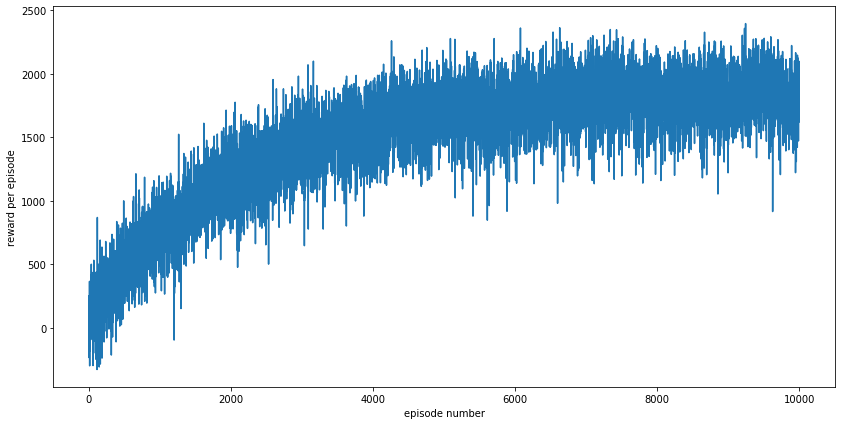

In [17]:
# plotting rewards per episode vs episode number
plt.figure(0, figsize=(14,7))
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")

#### The graph shows that the rewards increasing and stablized after 6000 episodes. The initial state is picked to be random for each episode, there are some initial states may be less rewarding than others.

### Plotting Q-value convergence of state-actions pair tracked

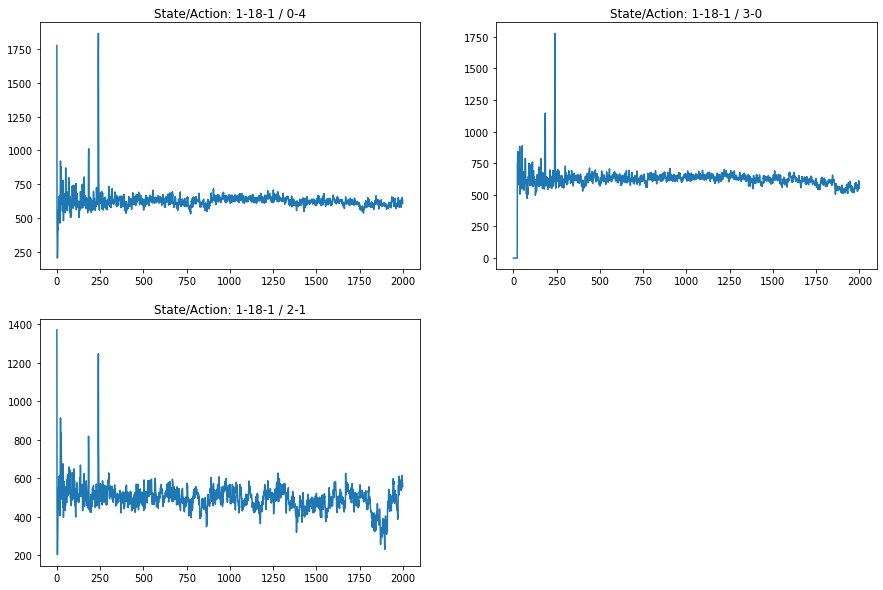

In [36]:
#plotting state-actions pair tracked
plt.figure(0, figsize=(15,10))

plot_poistion = 221

for action in States_track["1-18-1"].keys():
    x_data = np.asarray(range(0, len(States_track["1-18-1"][action] ) ) )
    plt.subplot(plot_poistion)
    plot_poistion = plot_poistion +1 
    plt.title("State/Action: {} / {}".format("1-18-1", action))
    plt.plot(x_data,np.asarray(States_track["1-18-1"][action]) )


plt.show()

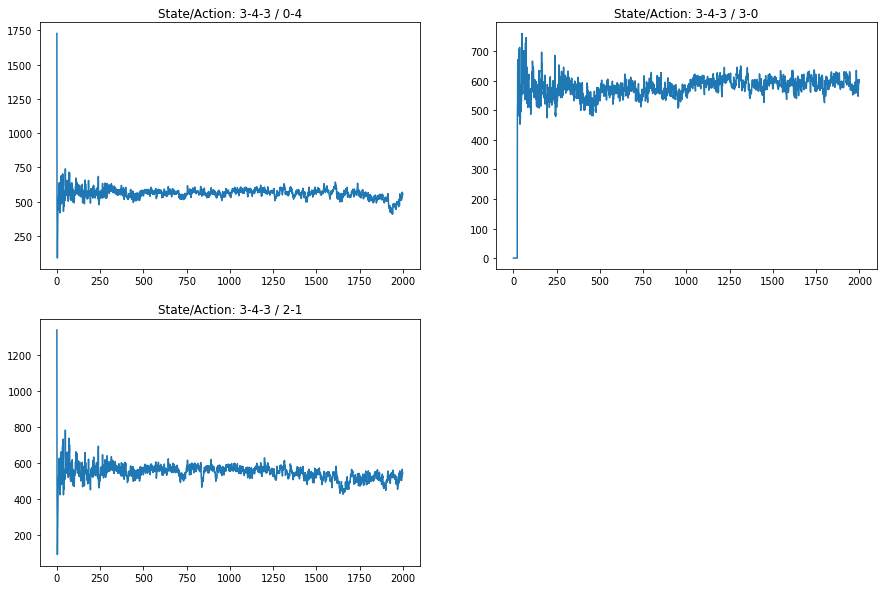

In [33]:
# sampled_states = [(1, 18, 1), (3, 4, 3), (2, 3, 3), (4, 16, 5)]

plt.figure(0, figsize=(15,10))

plot_poistion = 221

for action in States_track["3-4-3"].keys():
    x_data = np.asarray(range(0, len(States_track["3-4-3"][action] ) ) )
    plt.subplot(plot_poistion)
    plot_poistion = plot_poistion +1 
    plt.title("State/Action: {} / {}".format("3-4-3", action))
    plt.plot(x_data,np.asarray(States_track["3-4-3"][action]) )


plt.show()


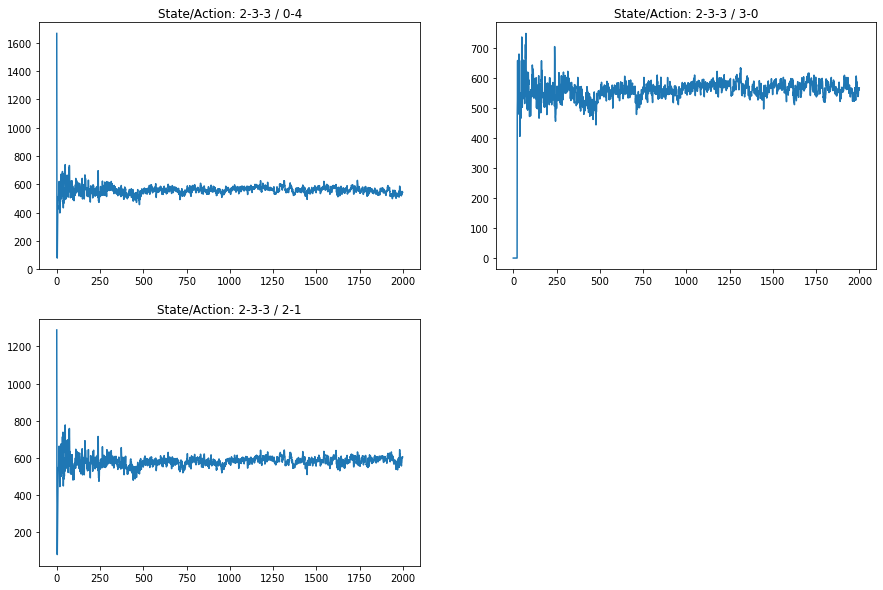

In [34]:
plt.figure(0, figsize=(15,10))

plot_poistion = 221

for action in States_track["2-3-3"].keys():
    x_data = np.asarray(range(0, len(States_track["2-3-3"][action] ) ) )
    plt.subplot(plot_poistion)
    plot_poistion = plot_poistion +1 
    plt.title("State/Action: {} / {}".format("2-3-3", action))
    plt.plot(x_data,np.asarray(States_track["2-3-3"][action]) )

plt.show()


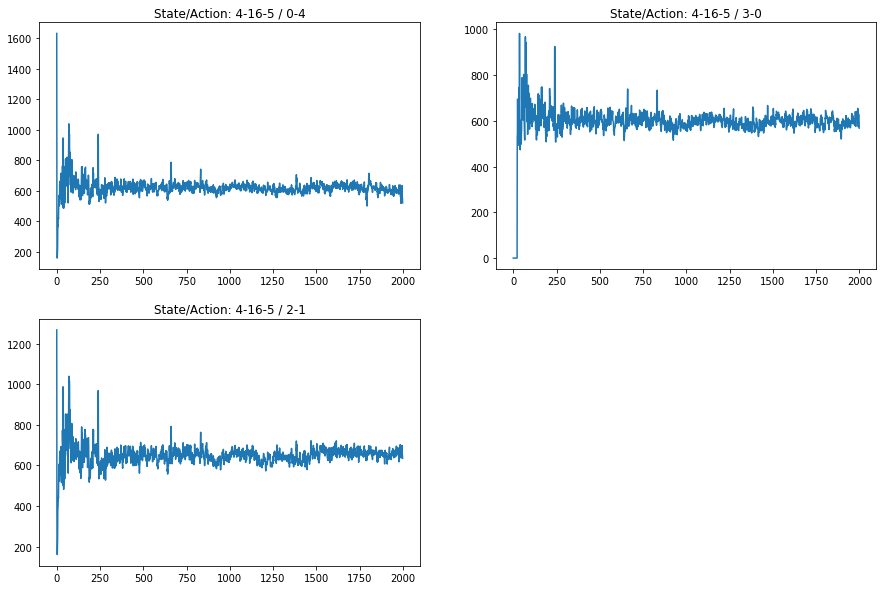

In [35]:
# sampled_states = [(1, 18, 1), (3, 4, 3), (2, 3, 3), (4, 16, 5)]

plt.figure(0, figsize=(15,10))

plot_poistion = 221

for action in States_track["4-16-5"].keys():
    x_data = np.asarray(range(0, len(States_track["4-16-5"][action] ) ) )
    plt.subplot(plot_poistion)
    plot_poistion = plot_poistion +1 
    plt.title("State/Action: {} / {}".format("4-16-5", action))
    plt.plot(x_data,np.asarray(States_track["4-16-5"][action]) )


plt.show()


#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [19]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0005*i))

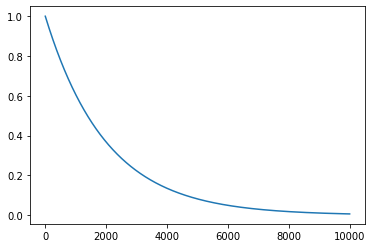

In [20]:
plt.plot(time, epsilon)
plt.show()